In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import re

In [2]:
base_dir = 'C:\\Users\\alvis\\Documents\\Thesis\\Results\\bbox'
eco_dir = os.path.join(base_dir, 'ECO')
siamrpn_dir = os.path.join(base_dir, 'siamrpn')
OTB100 = 'C:\\Users\\alvis\\Documents\\Thesis\\pysot\\testing_dataset\\OTB100'

In [3]:
eco_out = set(os.listdir(eco_dir))
siamrpn_out = set(os.listdir(siamrpn_dir))

common = list(siamrpn_out.intersection(eco_out))
# common.remove('BlurCar1_10.txt')

In [4]:
OCC = [
    'Basketball',
    'Biker',
    'Bolt',
    'Box',
    'CarScale',
    'ClifBar',
    'David',
    'DragonBaby',
    'Dudek',
    'Football ',
    'Freeman4 ',
    'Girl ',
    'Human3 ',
    'Human4 ',
    'Ironman ',
    'Jump ',
    'Liquor ',
    'Matrix ',
    'Panda ',
    'RedTeam ',
    'Skating1 ',
    'Skating2 ',
    'Soccer ',
    'Tiger ',
    'Walking ',
    'Walking2',
    'Woman',
    'Bird2 ',
    'Coke ',
    'Coupon ',
    'David3 ',
    'Doll ',
    'FaceOcc1 ',
    'FaceOcc2 ',
    'Girl2 ',
    'Human5',
    'Human7 ',
    'Jogging ',
    'KiteSurf ',
    'Lemming ',
    'Rubik',
    'Singer1 ',
    'Subway ',
    'Suv ',
    'Tiger1 ',
    'Trans',
]

In [5]:
Deformation = [
    'Basketball',
    'Bird1', 
    'Bird2', 
    'BlurBody', 
    'Bolt', 
    'Bolt2', 
    'Couple', 
    'Crossing', 
    'Crowds', 
    'Dancer', 
    'Dancer2', 
    'David', 
    'David3', 
    'Diving', 
    'Dog', 
    'Dudek', 
    'FleetFace', 
    'Girl2', 
    'Gym', 
    'Human3', 
    'Human4.2', 
    'Human5', 
    'Human6', 
    'Human7', 
    'Human8', 
    'Human9', 
    'Jogging.1', 
    'Jogging.2', 
    'Jump', 
    'Mhyang',
    'Panda', 
    'Singer2', 
    'Skater', 
    'Skater2', 
    'Skating1', 
    'Skating2.1', 
    'Skating2.2', 
    'Skiing', 
    'Subway', 
    'Tiger1', 
    'Tiger2', 
    'Trans', 
    'Walking', 
    'Woman'
]

In [6]:
metrics = {
    'OCC': OCC,
    'Deformation': Deformation
}

In [7]:
def bb_intersection_over_union(boxA, boxB):
    # print(boxA, boxB)
    # make sure all the values are intergers
    for i in range(0, 4):
        boxA[i] = int(boxA[i])
        boxB[i] = int(boxB[i])-1

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [8]:
def transform_gtbox(gt_bbox):
    gt_bbox = (gt_bbox[0], gt_bbox[1],
        gt_bbox[0]+gt_bbox[2], gt_bbox[1]+gt_bbox[3])
    return list(gt_bbox)

In [9]:
def smooth(v):
    lenght = 500
    div = int(v.shape[0]/500)
    v = v[:div * 500]
    return np.mean(v.reshape(-1, div), axis =1)

In [10]:
def append_reverse_np(item, times):
    tmp = np.array([item if i % 2 == 0 else list(reversed(item)) for i in range(times)])
    return tmp.reshape(item.shape[0]*times, 4)

In [11]:
def convert_center_to_bbb(bboxes):
    p1x = int(bboxes[0] - 1)
    p1y = int(bboxes[1] - 1)
    p2x = int(bboxes[0] + bboxes[2] - 1)
    p2y = int(bboxes[1] + bboxes[3] - 1)
    # return (p1x, p1y), (p2x, p2y)
    return np.array([p1x, p1y, p2x, p2y])


In [12]:
metrics_result = {}
for k, v in metrics.items():
    metrics_result[k] = ([], [])

siam_acc = []
eco_acc = []
for filename in common:
    print(filename)
    sample = re.search('(.*)_40.txt', filename).group(1)

    try:
        gt_bbox = np.loadtxt(os.path.join(OTB100, sample, 'groundtruth_rect.txt'), delimiter=',')
    except:
        gt_bbox = np.loadtxt(os.path.join(OTB100, sample, 'groundtruth_rect.txt'), delimiter='\t')
    siam_v = np.loadtxt(os.path.join(siamrpn_dir, filename), delimiter=',')
    eco_v = np.genfromtxt(os.path.join(eco_dir, filename), delimiter=',')
    min_dim = min(siam_v.shape[0], eco_v.shape[0])

    gt_bbox = append_reverse_np(gt_bbox, 10)
    siam_v = siam_v[:min_dim,:]
    eco_v = eco_v[:min_dim,:]
    gt_bbox = gt_bbox[:min_dim,:]
    sa = []
    ea = []
    for s, e, gt in zip(siam_v, eco_v, gt_bbox):
        # gt = convert_center_to_bbb(gt)
        s = convert_center_to_bbb(s)
        sa.append(bb_intersection_over_union(s, convert_center_to_bbb(gt)))
        ea.append(bb_intersection_over_union(e, transform_gtbox(gt)))
    sa = smooth(np.asarray(sa))
    ea = smooth(np.asarray(ea))
    siam_acc.append(sa)
    eco_acc.append(ea)
    for k, v in metrics_result.items():
        if sample in metrics[k]:
            v[0].append(sa)
            v[1].append(ea)

Doll_40.txt
Bird2_40.txt
BlurCar4_40.txt
Car24_40.txt
Basketball_40.txt
Car2_40.txt
ClifBar_40.txt
Couple_40.txt
Car4_40.txt
Coke_40.txt
BlurCar2_40.txt
FaceOcc1_40.txt
Woman_40.txt
BlurFace_40.txt
DragonBaby_40.txt
Dog_40.txt
Dog1_40.txt
Board_40.txt
Bird1_40.txt
BlurCar1_40.txt
BlurCar3_40.txt
Dancer_40.txt
Boy_40.txt
Dancer2_40.txt
Bolt2_40.txt
BlurBody_40.txt
Box_40.txt
CarDark_40.txt
BlurOwl_40.txt
Coupon_40.txt
Dudek_40.txt
Biker_40.txt
Car1_40.txt
Crossing_40.txt
David3_40.txt
Crowds_40.txt
CarScale_40.txt
Bolt_40.txt
David2_40.txt


In [13]:
siam_acc = np.array(siam_acc)
eco_acc = np.array(eco_acc)
for k, v in metrics_result.items():
    metrics_result[k]= (np.array(v[0]), np.array(v[1]))

In [14]:
metrics_result['OCC'][0].shape


(9, 500)

# Plot of the total dataset


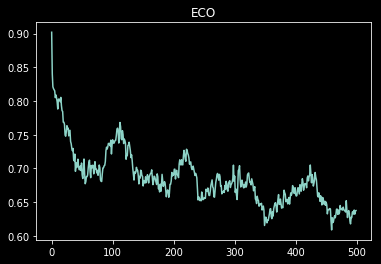

In [15]:
plt.plot(eco_acc.mean(axis=0))
plt.title('ECO')
plt.show()

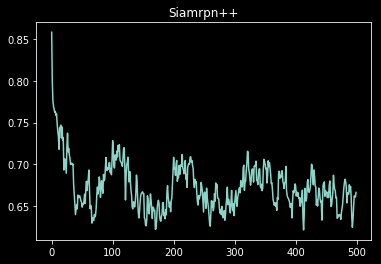

In [16]:
plt.plot(siam_acc.mean(axis=0))
plt.title('Siamrpn++')
plt.show()

# Plot of OCC subset

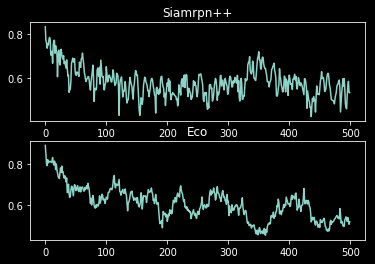

In [17]:
plt.subplot(2,1,1)
plt.title('Siamrpn++')
plt.plot(metrics_result['OCC'][0].mean(axis=0))
plt.subplot(2,1,2)
plt.title('Eco')
plt.plot(metrics_result['OCC'][1].mean(axis=0))
plt.show()

In [18]:
# Plot of deformation subset

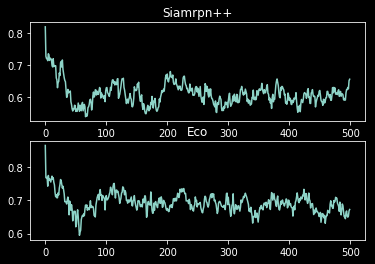

In [19]:
plt.subplot(2,1,1)
plt.title('Siamrpn++')
plt.plot(metrics_result['Deformation'][0].mean(axis=0))
plt.subplot(2,1,2)
plt.title('Eco')
plt.plot(metrics_result['Deformation'][1].mean(axis=0))
plt.show()

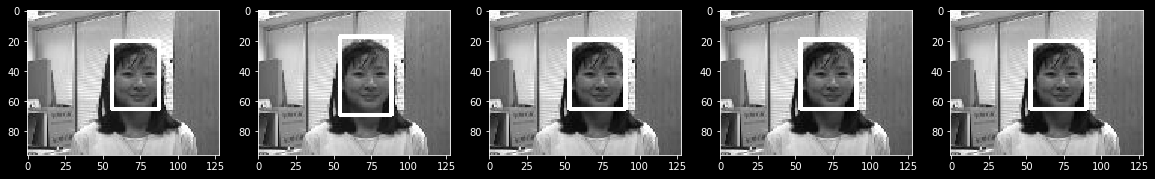

In [33]:
n_images = 500
siam_girl = np.loadtxt(os.path.join(siamrpn_dir, 'Girl_40.txt'), delimiter=',')


girl_path = os.path.join(OTB100, 'Girl', 'img')
img = cv2.imread(os.path.join(girl_path, '0001.jpg'),0)


plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(2,5,i+1)
    siam_img = img.copy()
    r0 = convert_center_to_bbb(siam_girl[2*i*n_images,:])
    cv2.rectangle(siam_img, (r0[0],r0[1]),(r0[2],r0[3]),(255,0,0), 2)
    plt.imshow(siam_img, cmap='gray')

    plt.subplot(2,5,5+i+1)
    eco_img = img.copy()
    e0 = transform_gtbox(siam_girl[2*i*n_images,:])
    cv2.rectangle(eco_img, (e0[0],e0[1]),(e0[2],e0[3]),(255,0,0), 2)
    plt.imshow(eco_img, cmap='gray')
plt.show()